##### Author: Adnan M Shaikh
##### Github: [10adnan75](https://github.com/10adnan75)

In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Comparing Fake News Classifiers

You can find the notebook on my [GitHub](https://github.com/10adnan75/Fake-news-detection/blob/master/attempting_to_detect_fake_news.ipynb).

In this notebook, I wanted to compare some of the features learned by each classifier to see if there was overlap or patterns in the features.

In [3]:
df = pd.read_csv('data/fake_or_real_news.csv')

In [4]:
y = df.label

In [5]:
df = df.drop('label', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

In [7]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [8]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [9]:
mn_count_clf = MultinomialNB(alpha=0.1) 

In [10]:
mn_count_clf.fit(count_train, y_train)
pred = mn_count_clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.893


In [11]:
mn_tfidf_clf = MultinomialNB(alpha=0.1) 

In [12]:
mn_tfidf_clf.fit(tfidf_train, y_train)
pred = mn_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.898


In [13]:
pa_tfidf_clf = PassiveAggressiveClassifier(C=50)

In [14]:
pa_tfidf_clf.fit(tfidf_train, y_train)
pred = pa_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.938


In [15]:
svc_tfidf_clf = LinearSVC()

In [16]:
svc_tfidf_clf.fit(tfidf_train, y_train)
pred = svc_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.936


In [17]:
sgd_tfidf_clf = SGDClassifier()

In [18]:
sgd_tfidf_clf.fit(tfidf_train, y_train)
pred = sgd_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.938


In [19]:
sgd_tfidf_clf.decision_function?

In [20]:
mn_count_clf.predict_proba?

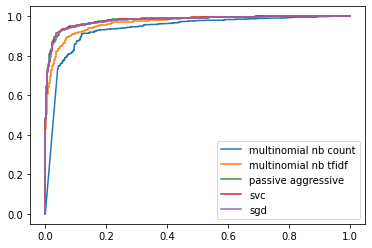

In [21]:
plt.figure(0).clf()

for model, name in [ (mn_count_clf, 'multinomial nb count'),
                     (mn_tfidf_clf, 'multinomial nb tfidf'),
                     (pa_tfidf_clf, 'passive aggressive'),
                     (svc_tfidf_clf, 'svc'),
                     (sgd_tfidf_clf, 'sgd')]:
    if 'count' in name:
        pred = model.predict_proba(count_test)[:,1]
    elif 'multinomial' in name:
        pred = model.predict_proba(tfidf_test)[:,1]
    else: 
        pred = model.decision_function(tfidf_test)
    fpr, tpr, thresh = metrics.roc_curve(y_test.values, pred, pos_label='REAL')
    plt.plot(fpr,tpr,label="{}".format(name))

plt.legend(loc=0)

In [22]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    return { class_labels[0]: topn_class1,
             class_labels[1]: topn_class2 }

most_informative_feature_for_binary_classification(tfidf_vectorizer, pa_tfidf_clf, n=10)

{'FAKE': [(-5.136295921839383, '2016'),
  (-4.338967562025053, 'october'),
  (-4.262804936181744, 'hillary'),
  (-3.196737843454812, 'share'),
  (-2.9875226459333977, 'article'),
  (-2.637324175485897, 'november'),
  (-2.6287379764943206, 'print'),
  (-2.4468676596086385, 'email'),
  (-2.386147034054906, 'advertisement'),
  (-2.3646229887906354, 'oct')],
 'REAL': [(2.2234701867361664, 'marriage'),
  (2.240884116896919, 'friday'),
  (2.25271611439302, 'monday'),
  (2.296110448155009, 'islamic'),
  (2.3002437319698403, 'jobs'),
  (2.555125888606341, 'gop'),
  (2.579113719781955, 'cruz'),
  (2.8153261740443334, 'says'),
  (2.8767791134909455, 'tuesday'),
  (4.946805566220489, 'said')]}

In [23]:
classifiers = [(mn_count_clf, count_vectorizer),
               (mn_tfidf_clf, tfidf_vectorizer),
               (pa_tfidf_clf, tfidf_vectorizer),
               (svc_tfidf_clf, tfidf_vectorizer),
               (sgd_tfidf_clf, tfidf_vectorizer)]

In [24]:
results = {}
for clf, vct in classifiers:
    results[clf] = most_informative_feature_for_binary_classification(vct, clf, n=10)

/home/adnan_07/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [25]:
results

{MultinomialNB(alpha=0.1): {'FAKE': [(-16.067750538483136, '0000'),
   (-16.067750538483136, '000035'),
   (-16.067750538483136, '0001'),
   (-16.067750538483136, '0001pt'),
   (-16.067750538483136, '000km'),
   (-16.067750538483136, '0011'),
   (-16.067750538483136, '006s'),
   (-16.067750538483136, '007'),
   (-16.067750538483136, '007s'),
   (-16.067750538483136, '008s')],
  'REAL': [(-5.675959082863306, 'republican'),
   (-5.582298794347825, 'campaign'),
   (-5.520542422049422, 'new'),
   (-5.463370874939617, 'state'),
   (-5.459162531269605, 'obama'),
   (-5.429949870021241, 'president'),
   (-5.403667459399097, 'people'),
   (-4.929358535752954, 'clinton'),
   (-4.541306857712, 'trump'),
   (-4.424753408851144, 'said')]},
 MultinomialNB(alpha=0.1): {'FAKE': [(-12.641778440826338, '0000'),
   (-12.641778440826338, '000035'),
   (-12.641778440826338, '0001'),
   (-12.641778440826338, '0001pt'),
   (-12.641778440826338, '000km'),
   (-12.641778440826338, '0011'),
   (-12.64177844082

In [26]:
comparable_results = {'REAL': {}, 'FAKE': {}}
for clf, data in results.items():
    clf_name = clf.__class__.__name__
    for label, features in data.items():
        for rank, score_tuple in enumerate(features):
            if score_tuple[1] in comparable_results[label]:
                comparable_results[label][score_tuple[1]].append((rank + 1, clf_name))
            else:
                comparable_results[label][score_tuple[1]] = [(rank + 1, clf_name)]

In [27]:
comparable_results['FAKE']

{'0000': [(1, 'MultinomialNB'), (1, 'MultinomialNB')],
 '000035': [(2, 'MultinomialNB'), (2, 'MultinomialNB')],
 '0001': [(3, 'MultinomialNB'), (3, 'MultinomialNB')],
 '0001pt': [(4, 'MultinomialNB'), (4, 'MultinomialNB')],
 '000km': [(5, 'MultinomialNB'), (5, 'MultinomialNB')],
 '0011': [(6, 'MultinomialNB'), (6, 'MultinomialNB')],
 '006s': [(7, 'MultinomialNB'), (7, 'MultinomialNB')],
 '007': [(8, 'MultinomialNB'), (8, 'MultinomialNB')],
 '007s': [(9, 'MultinomialNB'), (9, 'MultinomialNB')],
 '008s': [(10, 'MultinomialNB'), (10, 'MultinomialNB')],
 '2016': [(1, 'PassiveAggressiveClassifier'),
  (1, 'LinearSVC'),
  (2, 'SGDClassifier')],
 'october': [(2, 'PassiveAggressiveClassifier'),
  (3, 'LinearSVC'),
  (3, 'SGDClassifier')],
 'hillary': [(3, 'PassiveAggressiveClassifier'),
  (2, 'LinearSVC'),
  (1, 'SGDClassifier')],
 'share': [(4, 'PassiveAggressiveClassifier'),
  (6, 'LinearSVC'),
  (6, 'SGDClassifier')],
 'article': [(5, 'PassiveAggressiveClassifier'),
  (4, 'LinearSVC'),
  (4

In [28]:
agg_results = {}
for label, features in comparable_results.items():
    for feature, ranks in features.items():
        if feature in agg_results:
            print("WARNING! DUPLICATE LABEL!!! {}".format(feature))
        agg_results[feature] = {
            'label': label,
            'agg_rank': np.mean([r[0] for r in ranks]),
            'count': len(ranks)
        }

In [29]:
comparison_df = pd.DataFrame(agg_results).T

In [30]:
comparison_df.head()

,label,agg_rank,count
republican,REAL,2.0,2
campaign,REAL,3.0,2
new,REAL,3.0,1
state,REAL,3.0,2
obama,REAL,6.0,2


In [31]:
comparison_df[comparison_df['label'] == 'REAL'].sort_values('count', ascending=0).head(10)

,label,agg_rank,count
said,REAL,9.8,5
cruz,REAL,3.0,4
says,REAL,8.0,3
islamic,REAL,4.666667,3
monday,REAL,3.333333,3
friday,REAL,3.333333,3
tuesday,REAL,9.0,3
gop,REAL,4.666667,3
campaign,REAL,3.0,2
republican,REAL,2.0,2


In [32]:
comparison_df[comparison_df['label'] == 'FAKE'].sort_values('count', ascending=0).head(10)

,label,agg_rank,count
october,FAKE,2.666667,3
print,FAKE,7.333333,3
november,FAKE,5.333333,3
article,FAKE,4.333333,3
share,FAKE,5.333333,3
hillary,FAKE,2.0,3
2016,FAKE,1.333333,3
000035,FAKE,2.0,2
election,FAKE,7.5,2
advertisement,FAKE,9.5,2


In [33]:
feature_names = count_vectorizer.get_feature_names()
for idx, ftr_weight in enumerate(sorted(zip(mn_count_clf.coef_[0], feature_names))):
    if ftr_weight[0] <= -16.067750538483136:
        continue
    print(idx, ftr_weight)
    break

20161 (-13.669855265684765, '00000031')


/home/adnan_07/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


### Conclusion

As expected, the bag-of-words and TF-IDF vectors didn't do much to determine meaningful features to classify fake or real news.

That said, I did learn a few things. Namely, that linear models handle noise in this case better than the Naive Bayes multinomial classifier did. Also, finding a good dataset that has been scraped from the web and tagged for this problem would likely be a great help, and worth more of my time than parameter tuning on a clearly noisy and error prone dataset.

If you spend some time researching and find anything interesting, feel free to share your findings and notes in the comments or you can always reach out on Twitter (I'm [@10adnan75](https://twitter.com/10adnan75)).

I hope you had some fun exploring a new NLP dataset with me!